In [ ]:
# Step 0: Import necessary files to start
import os
import pandas as pd
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
import matplotlib.pyplot as plt

# Create results directory if not exists
os.makedirs("results", exist_ok=True)

# Initialize Excel writer
excel_writer = pd.ExcelWriter("results/results_summary.xlsx", engine="openpyxl")

In [ ]:
# Step 1: Load and Clean Data
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# 1.1 Load the dataset
file_path = 'The_Student_Dataset.csv'
df = pd.read_csv(file_path)
df.drop(columns=['Age as of Academic Year 17/18','Current Year (17/18)',
                 'Proposed Year/Grade (18/19)','Current School ','Current Curriculum ','Previous year/Grade ',
                 'Gender','Previous Curriculum (17/18)2'], inplace=True)

# 1.2 Clean column names: remove leading/trailing spaces, replace spaces with underscores, remove non-alphanumeric characters
df.columns = df.columns.str.strip()  # Remove leading/trailing spaces from column names
df.columns = df.columns.str.replace(r'\s+', '_', regex=True)  # Replace spaces with underscores
df.columns = df.columns.str.replace(r'[^a-zA-Z0-9_]', '', regex=True)  # Remove non-alphanumeric characters

In [ ]:
# Step 2: Handle missing values: fill categorical with mode, numerical with mean
for col in df.columns:
    if df[col].isnull().sum() > 0:  # If there are null values in the column
        if df[col].dtype == 'object':  # For categorical columns (strings)
            mode_value = df[col].mode()[0]  # Get the most frequent value
            df[col].fillna(mode_value, inplace=True)
        else:  # For numerical columns
            mean_value = df[col].mean()  # Get the mean value
            df[col].fillna(mean_value, inplace=True)

<ipython-input-3-15935aa81d4c>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mean_value, inplace=True)


In [ ]:
# Step 3: Encode Categorical Data to Numerical
categorical_columns = df.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])  # Convert categorical to numerical
    label_encoders[col] = le  # Save the encoder for future reference

# 3.1 Save the preprocessed data and mappings
output_file_path = 'The_Student_Dataset_Preprocessed.xlsx'
mapping_data = []

for col, le in label_encoders.items():
    category_mapping = {index: label for index, label in enumerate(le.classes_)}
    mapping_data.append({"Column Name": col, "Mapping": category_mapping})

mapping_df = pd.DataFrame(mapping_data)

# 3.2 Write the cleaned data and mapping data to an Excel file
with pd.ExcelWriter(output_file_path) as writer:
    df.to_excel(writer, sheet_name='Data', index=False)
    mapping_df.to_excel(writer, sheet_name='Mappings')

print(f"Preprocessing complete. Dataset saved to: {output_file_path}")

Preprocessing complete. Dataset saved to: The_Student_Dataset_Preprocessed.xlsx


In [ ]:
# Step 4: Calculate average for each subject in 2019
df['Math_2019'] = df[['Math191_', 'Math192_', 'Math193_']].mean(axis=1)
df['Science_2019'] = df[['Science191_', 'Science192_', 'Science193_']].mean(axis=1)
df['English_2019'] = df[['English191_', 'English192_', 'English193_']].mean(axis=1)

In [ ]:
# 5.1 For Math
math_corr = df[['Mathexam', 'Math_2019']].corr().iloc[0, 1]

# 5.2 For Science
science_corr = df[['Scienceexam_', 'Science_2019']].corr().iloc[0, 1]

# 5.3 For English
english_corr = df[['Englishexam_', 'English_2019']].corr().iloc[0, 1]

# Print the correlation coefficients clearly
print("Correlation Coefficients:")
print(f"Math:    {math_corr:.3f}")
print(f"Science: {science_corr:.3f}")
print(f"English: {english_corr:.3f}")

Correlation Coefficients:
Math:    0.010
Science: 0.007
English: 0.076


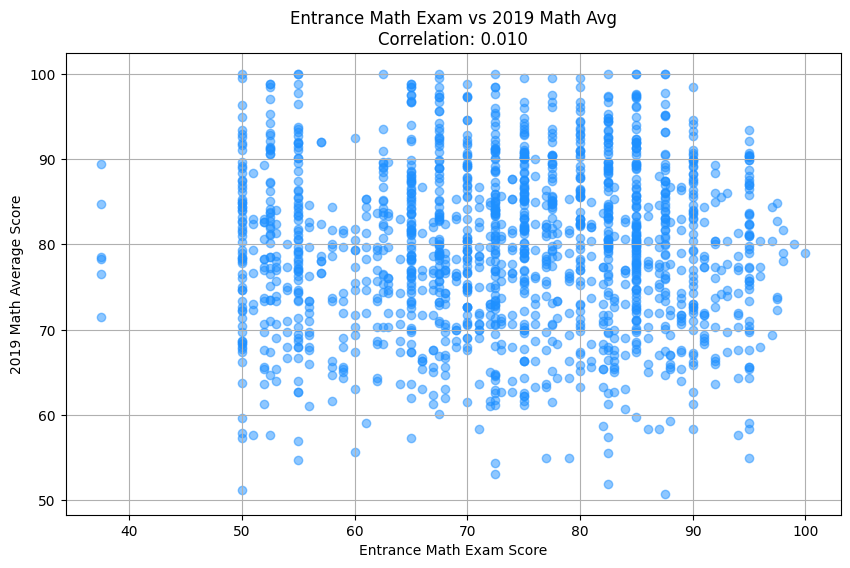

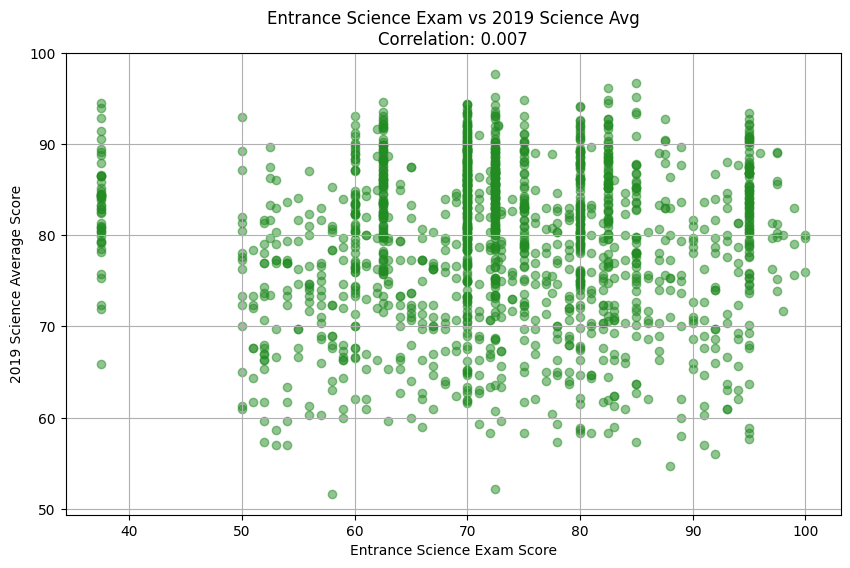

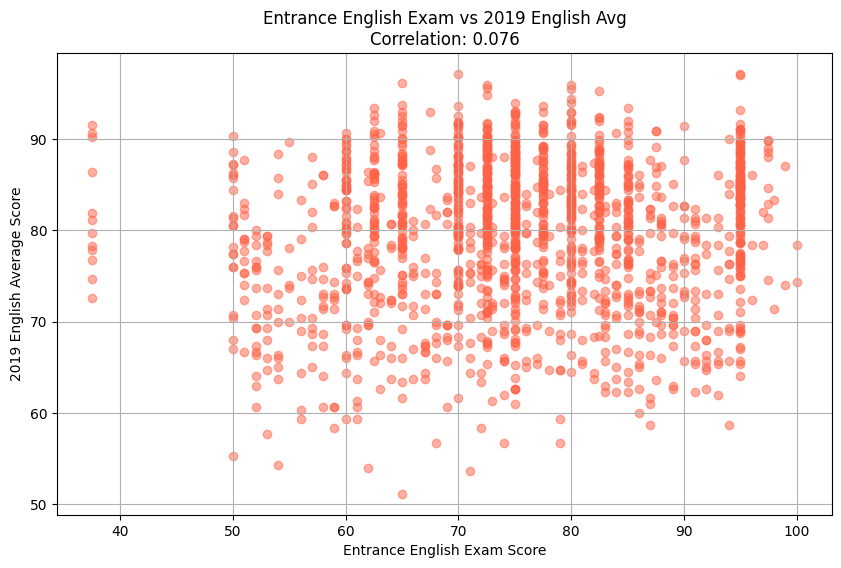

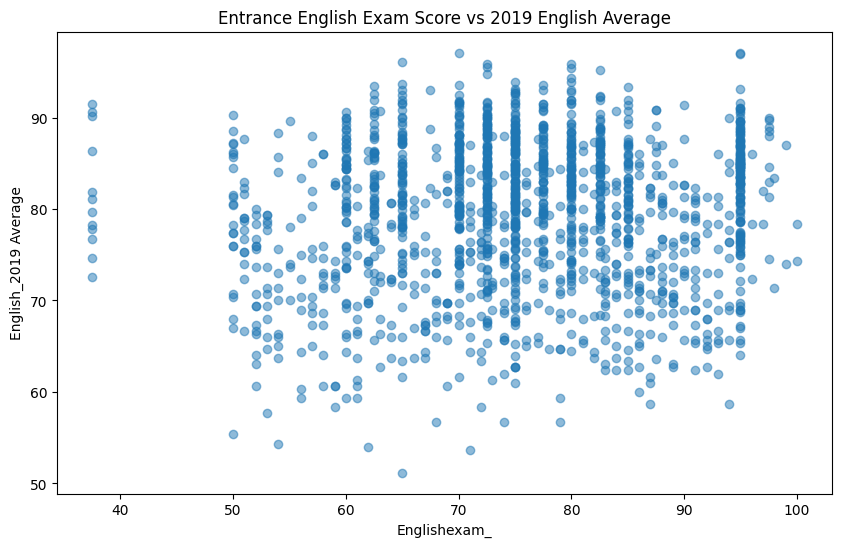

In [ ]:
# Step 6: Visualize the data with correlation in titles

import matplotlib.pyplot as plt

# 6.1 Scatter plot for Math
plt.figure(figsize=(10, 6))
plt.scatter(df['Mathexam'], df['Math_2019'], alpha=0.5, color='dodgerblue')
plt.title(f'Entrance Math Exam vs 2019 Math Avg\nCorrelation: {math_corr:.3f}')
plt.xlabel('Entrance Math Exam Score')
plt.ylabel('2019 Math Average Score')
plt.grid(True)
plt.show()

# 6.2 Scatter plot for Science
plt.figure(figsize=(10, 6))
plt.scatter(df['Scienceexam_'], df['Science_2019'], alpha=0.5, color='forestgreen')
plt.title(f'Entrance Science Exam vs 2019 Science Avg\nCorrelation: {science_corr:.3f}')
plt.xlabel('Entrance Science Exam Score')
plt.ylabel('2019 Science Average Score')
plt.grid(True)
plt.show()

# 6.3 Scatter plot for English
plt.figure(figsize=(10, 6))
plt.scatter(df['Englishexam_'], df['English_2019'], alpha=0.5, color='tomato')
plt.title(f'Entrance English Exam vs 2019 English Avg\nCorrelation: {english_corr:.3f}')
plt.xlabel('Entrance English Exam Score')
plt.ylabel('2019 English Average Score')
plt.grid(True)
plt.show()

# 6.3 Scatter plot for English
plt.figure(figsize=(10, 6))
plt.scatter(df['Englishexam_'], df['English_2019'], alpha=0.5)
plt.title('Entrance English Exam Score vs 2019 English Average')
plt.xlabel('Englishexam_')
plt.ylabel('English_2019 Average')
plt.show()

In [ ]:
# Step 7: Prepare target variable (classification based on 2019 average)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# 7.1 Create Overall Average Score
df['Overall_2019'] = df[['Math_2019', 'Science_2019', 'English_2019']].mean(axis=1)

# 7.2 Create class labels: Low (<60), Medium (60–79), High (80+)
def categorize_performance(score):
    if score >= 80:
        return 'High'
    else:
        return 'Low'

df['Performance_Class'] = df['Overall_2019'].apply(categorize_performance)

# 7.3 Features and target
feature_cols = ['Mathexam', 'Scienceexam_', 'Englishexam_']
X = df[feature_cols]
y = df['Performance_Class']

# 7.4 Encode labels
from sklearn.preprocessing import LabelEncoder
le_perf = LabelEncoder()
y_encoded = le_perf.fit_transform(y)

# 7.5 Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


--- Random Forest ---
Accuracy: 0.7580645161290323
Classification Report:
               precision    recall  f1-score   support

        High       0.69      0.88      0.77       144
         Low       0.86      0.65      0.74       166

    accuracy                           0.76       310
   macro avg       0.78      0.77      0.76       310
weighted avg       0.78      0.76      0.76       310



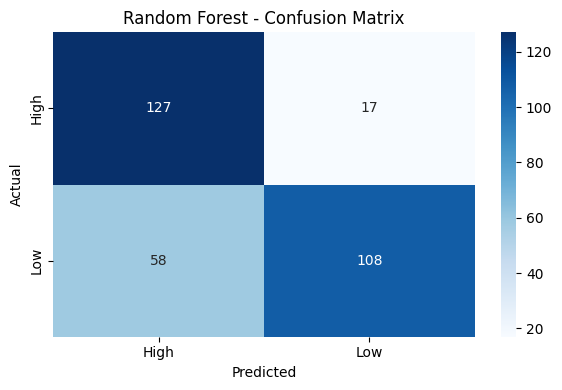


--- XGBoost ---

C:\Users\lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:23:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Accuracy: 0.7516129032258064
Classification Report:
               precision    recall  f1-score   support

        High       0.68      0.90      0.77       144
         Low       0.87      0.63      0.73       166

    accuracy                           0.75       310
   macro avg       0.77      0.76      0.75       310
weighted avg       0.78      0.75      0.75       310



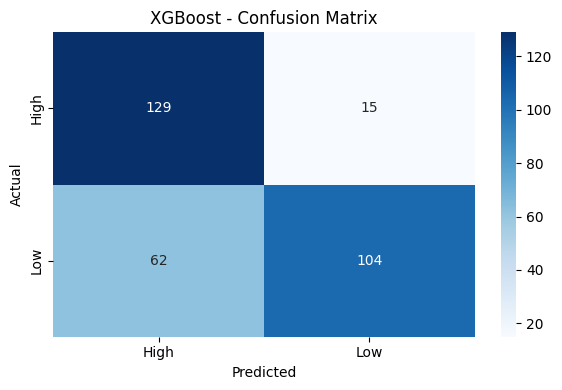

[LightGBM] [Info] Number of positive: 607, number of negative: 632
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 1239, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.489911 -> initscore=-0.040361
[LightGBM] [Info] Start training from score -0.040361

--- LightGBM ---
Accuracy: 0.7548387096774194
Classification Report:
               precision    recall  f1-score   support

        High       0.68      0.90      0.77       144
         Low       0.88      0.63      0.73       166

    accuracy                           0.75       310
   macro avg       0.78      0.76      0.75       310
weighted avg       0.78      0.75      0.75       310



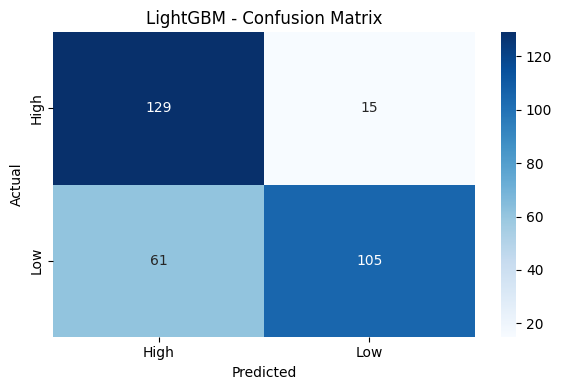


--- Support Vector Machine ---
Accuracy: 0.6709677419354839
Classification Report:
               precision    recall  f1-score   support

        High       0.61      0.83      0.70       144
         Low       0.78      0.54      0.64       166

    accuracy                           0.67       310
   macro avg       0.69      0.68      0.67       310
weighted avg       0.70      0.67      0.67       310



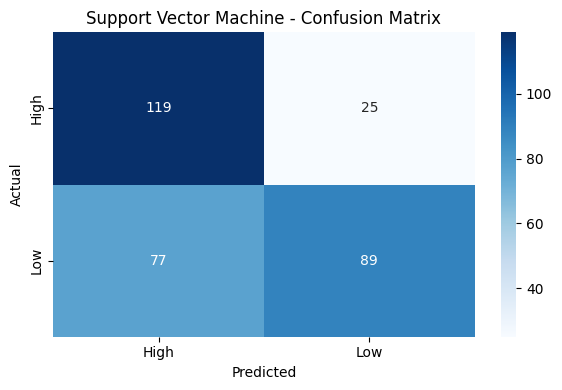

In [ ]:
# Step 8: Model Training and Evaluation

def evaluate_model(name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n--- {name} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le_perf.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=le_perf.classes_, yticklabels=le_perf.classes_, cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


# 8.1 Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_model("Random Forest", rf_model)

# 8.2 XGBoost
from xgboost import XGBClassifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
evaluate_model("XGBoost", xgb_model)

# 8.3 LightGBM
from lightgbm import LGBMClassifier
lgbm_model = LGBMClassifier(random_state=42)
evaluate_model("LightGBM", lgbm_model)

# 8.4 SVM
from sklearn.svm import SVC
svm_model = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
evaluate_model("Support Vector Machine", svm_model)